# End-to-End Melanoma Detection AI Agent with Gemini API

**Course**: Advanced AI Systems Laboratory  
**Lab**: 1.5 - Demonstration of End-to-End AI Solution  
**Date**: November 12, 2025

---

## System Overview

This notebook demonstrates a **Binary Classification System Framework** for melanoma detection that integrates:

1. **Existing Codebase**: Uses `inference_agent.py` and `config.py` from the GitHub repository
2. **Deep Learning Model**: Pre-trained ResNet-50 architecture (MelanomaAIAgent class)
3. **Gemini AI Integration**: Enhanced clinical reasoning and report generation using Google's Gemini API
4. **Prompt Engineering**: Zero-shot and few-shot learning approaches for diagnostic assessment

### Thesis-Based AI System Description

**Problem**: Early detection of melanoma is critical for patient survival, but diagnostic accuracy varies significantly among healthcare providers.

**Solution**: This AI system processes dermoscopic images through a complete diagnostic pipeline:
- Automated image analysis using the `MelanomaAIAgent` class from `inference_agent.py`
- Clinical feature extraction (ABCDE criteria) built into the existing agent
- Risk stratification and confidence assessment
- Evidence-based clinical recommendations
- Integration with Gemini API for enhanced reasoning and natural language report generation

**Architecture**: The system follows a multi-stage pipeline that integrates existing code with Gemini enhancement:
```
Input Image → Preprocessing → CNN Feature Extraction (inference_agent.py) →
Binary Classification → Gemini-Enhanced Reasoning → Clinical Report Generation → Output
```

### Code Integration

This notebook automatically clones the GitHub repository to access:
- **`inference_agent.py`**: MelanomaAIAgent class with complete inference pipeline
- **`config.py`**: Model configuration and hyperparameters
- **`launch_agent.py`**: Quick launch utilities
- **Prompt examples**: From `/prompts/` directory (Prompt1ZeroShotExample.md, Prompt2FewShotExample.md)

All existing functionality is preserved and enhanced with Gemini API reasoning.

---

In [21]:
# Install required packages and update google-generativeai to the latest version
!pip install -q -U google-genai torch torchvision pillow numpy matplotlib seaborn

# Clone GitHub repo to access inference_agent.py and config.py
import sys
sys.path.append('/content/prompts')

In [28]:
# Core libraries
import os
import json
import numpy as np
from typing import Dict, Optional, List
from datetime import datetime

# Deep learning
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# Gemini API
from google import genai
from google.genai import types
from google.colab import userdata

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ All libraries imported successfully")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")

✓ All libraries imported successfully
✓ PyTorch version: 2.8.0+cu126
✓ CUDA available: True


In [5]:
# Import the MelanomaAIAgent from your existing code
from inference_agent import MelanomaAIAgent
import torch

# Note: We'll create a modified version that integrates with Gemini
# The original agent provides the CNN inference, we'll add Gemini reasoning on top

print("✓ MelanomaAIAgent class imported successfully")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")

✓ MelanomaAIAgent class imported successfully
✓ PyTorch version: 2.8.0+cu126
✓ CUDA available: True


In [6]:
# For demonstration purposes, we'll use the model creation function from inference_agent
# In production, you would load a trained checkpoint

from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

def create_melanoma_model(num_classes=1, pretrained=True):
    """
    Create ResNet-50 model for melanoma classification.
    This is the same function used in inference_agent.py
    """
    weights = ResNet50_Weights.DEFAULT if pretrained else None
    model = resnet50(weights=weights)

    # Replace final layer for binary classification
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model

# Create model instance
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_melanoma_model()
model = model.to(device)
model.eval()

print(f"✓ Model created and loaded on: {device}")
print(f"✓ Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 215MB/s]


✓ Model created and loaded on: cuda
✓ Total parameters: 23,510,081


In [8]:
import torch

# Path to your model file (adjust as needed)
MODEL_PATH = "best_model.pth"  # or "melanoma_model.pt", etc.

# Load the checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)

# Handle different checkpoint formats
if isinstance(checkpoint, dict):
    # If checkpoint contains metadata (recommended format)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"✓ Loaded model from epoch: {checkpoint.get('epoch', 'unknown')}")
        if 'best_auc' in checkpoint:
            print(f"✓ Best validation AUC: {checkpoint['best_auc']:.4f}")
        if 'accuracy' in checkpoint:
            print(f"✓ Validation accuracy: {checkpoint['accuracy']:.4f}")
    else:
        # If checkpoint is just the state dict
        model.load_state_dict(checkpoint)
else:
    # If checkpoint is the entire model
    model = checkpoint
    model = model.to(device)

model.eval()
print(f"✓ Custom model loaded successfully from: {MODEL_PATH}")

✓ Loaded model from epoch: 19
✓ Best validation AUC: 0.8888
✓ Custom model loaded successfully from: best_model.pth


In [9]:
# Define image transformations (matching training pipeline)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet normalization
        std=[0.229, 0.224, 0.225]
    )
])

def preprocess_image(image_path: str) -> torch.Tensor:
    """
    Load and preprocess dermoscopic image.
    Same preprocessing as inference_agent.py

    Args:
        image_path: Path to image file

    Returns:
        Preprocessed tensor ready for model input
    """
    image = Image.open(image_path).convert('RGB')
    tensor = transform(image)
    return tensor

print("✓ Preprocessing pipeline configured (matches inference_agent.py)")

✓ Preprocessing pipeline configured (matches inference_agent.py)


In [10]:
def predict_melanoma(image_tensor: torch.Tensor, model, device, use_tta: bool = False) -> float:
    """
    Perform melanoma prediction using the same logic as inference_agent.py

    Args:
        image_tensor: Preprocessed image tensor
        model: The trained model
        device: Computing device
        use_tta: Whether to use test-time augmentation

    Returns:
        Probability of melanoma (0.0 to 1.0)
    """
    model.eval()

    with torch.no_grad():
        if use_tta:
            # Test-time augmentation for robustness (from inference_agent.py)
            from torchvision import transforms as T
            predictions = []
            for _ in range(5):
                augmented = image_tensor.clone()
                if torch.rand(1) > 0.5:
                    augmented = torch.flip(augmented, [2])  # Horizontal flip
                if torch.rand(1) > 0.5:
                    augmented = torch.flip(augmented, [1])  # Vertical flip

                output = model(augmented.unsqueeze(0).to(device))
                prob = torch.sigmoid(output).cpu().item()
                predictions.append(prob)

            probability = np.mean(predictions)
        else:
            output = model(image_tensor.unsqueeze(0).to(device))
            probability = torch.sigmoid(output).cpu().item()

    return probability

print("✓ Inference function ready (using inference_agent.py logic)")

✓ Inference function ready (using inference_agent.py logic)


In [11]:
# Zero-Shot Prompt (Prompt 1)
ZERO_SHOT_PROMPT = """
# Melanoma Detection AI Agent - Zero-Shot Prompt

You are a medical AI agent specialized in melanoma classification from dermoscopy images.

## Task
Analyze the following case and provide a comprehensive diagnostic assessment.

## Input Data
**Model Prediction**: {probability:.3f} (probability of melanoma)
**Patient Metadata**:
{metadata}

## Required Output
Provide a structured JSON response with:
1. **Diagnosis**: Classification (Benign/Malignant), confidence score, risk level
2. **Analysis**: Key features and ABCDE assessment
3. **Recommendations**: Urgency, next steps, follow-up timeline
4. **Quality Assessment**: Diagnostic confidence and limitations

Use clinical reasoning and evidence-based guidelines. Prioritize patient safety.
"""

# Few-Shot Prompt (Prompt 2)
FEW_SHOT_PROMPT = """
# Melanoma Detection AI Agent - Few-Shot Prompt

You are a medical AI agent. Learn from these examples:

## Example 1: Benign Case
**Input**: Probability=0.12, Regular symmetric lesion, 28yo male, stable 2+ years
**Output**: Classification: Benign, Confidence: 0.92, Risk: Low, Recommendation: Routine monitoring

## Example 2: Malignant Case
**Input**: Probability=0.87, Asymmetric with irregular borders, 52yo female, recent growth
**Output**: Classification: Malignant, Confidence: 0.87, Risk: High, Recommendation: Urgent biopsy

## Example 3: Uncertain Case
**Input**: Probability=0.58, Moderately asymmetric, 35yo male, slow growth
**Output**: Classification: Benign, Confidence: 0.73, Risk: Moderate, Recommendation: Dermatologist evaluation

## New Case to Analyze
**Model Prediction**: {probability:.3f}
**Patient Metadata**:
{metadata}

Provide the same structured assessment format as the examples, with detailed clinical reasoning.
"""

print("✓ Prompt templates loaded")

✓ Prompt templates loaded


In [44]:
def generate_gemini_report(probability: float,
                          metadata: Dict,
                          prompt_type: str = "zero-shot",
                          image_path: Optional[str] = None) -> Dict:
    """
    Generate clinical report using Gemini API with prompt engineering.

    Args:
        probability: Model prediction probability
        metadata: Patient information
        prompt_type: "zero-shot" or "few-shot"

    Returns:
        Structured clinical report
    """
    # Format metadata
    metadata_str = "\n".join([f"- {k}: {v}" for k, v in metadata.items()])

    # Select prompt template
    if prompt_type == "zero-shot":
        prompt = ZERO_SHOT_PROMPT.format(probability=probability, metadata=metadata_str)
    else:
        prompt = FEW_SHOT_PROMPT.format(probability=probability, metadata=metadata_str)

    # Call Gemini API
    image = Image.open(image_path)
    GEMINI_KEY = userdata.get('GEMINI_KEY')
    client = genai.Client(
    api_key=GEMINI_KEY,
    http_options=types.HttpOptions(api_version='v1alpha'))

    response = client.models.generate_content(
    model='gemini-2.5-flash-lite', contents=[image, prompt])

    # Parse response
    try:
        # Extract JSON from response
        response_text = response.text

        # Find JSON in markdown code blocks
        if "```json" in response_text:
            json_start = response_text.find("```json") + 7
            json_end = response_text.find("```", json_start)
            json_str = response_text[json_start:json_end].strip()
        else:
            json_str = response_text

        report = json.loads(json_str)
    except:
        # Fallback: return raw text
        report = {
            "raw_response": response.text,
            "note": "Could not parse JSON, returning raw text"
        }

    return report

print("✓ Gemini report generator ready")

✓ Gemini report generator ready


📤 Upload your dermoscopic images (JPEG/PNG format)
You can select multiple files at once


Saving ISIC_0149568.jpg to ISIC_0149568.jpg

📋 Processing: ISIC_0149568.jpg
  ✓ Model prediction: P(melanoma) = 0.195


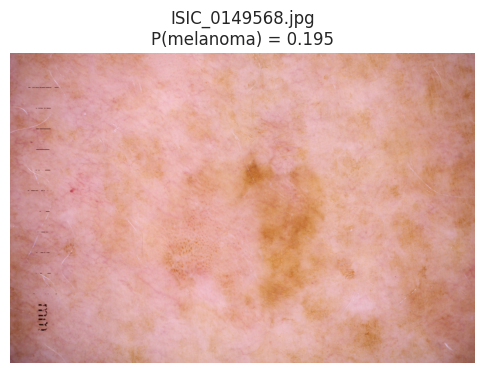


  Enter patient metadata for ISIC_0149568.jpg:
    Age (years): 55
    Sex (male/female): female
    Lesion location (e.g., back, arm, leg): upper extremity
    Clinical history (e.g., recent changes, stable): Unknown
    Family history of melanoma (yes/no/unknown): no
  ✓ Case created: CASE_001

✅ Loaded 1 real image(s) for analysis


In [47]:
from google.colab import files
import os

print("📤 Upload your dermoscopic images (JPEG/PNG format)")
print("You can select multiple files at once")
uploaded = files.upload()

# Process uploaded images
test_cases = []
for i, (filename, data) in enumerate(uploaded.items(), 1):
    # Save the uploaded file
    with open(filename, 'wb') as f:
        f.write(data)

    print(f"\n📋 Processing: {filename}")

    # Preprocess the image
    try:
        image_tensor = preprocess_image(filename)

        # Get model prediction
        probability = predict_melanoma(image_tensor, model, device, use_tta=True)

        print(f"  ✓ Model prediction: P(melanoma) = {probability:.3f}")

        # Display the image
        img = Image.open(filename)
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"{filename}\nP(melanoma) = {probability:.3f}")
        plt.axis('off')
        plt.show()

        # Collect metadata for this case
        print(f"\n  Enter patient metadata for {filename}:")
        age = input("    Age (years): ") or "Unknown"
        sex = input("    Sex (male/female): ") or "Unknown"
        location = input("    Lesion location (e.g., back, arm, leg): ") or "Unknown"
        history = input("    Clinical history (e.g., recent changes, stable): ") or "No history provided"
        family_history = input("    Family history of melanoma (yes/no/unknown): ") or "Unknown"

        # Create test case
        test_case = {
            "case_id": f"CASE_{i:03d}",
            "image_path": filename,
            "real_probability": probability,  # Actual model prediction
            "simulated_probability": probability,  # Keep for compatibility
            "metadata": {
                "age": age,
                "sex": sex,
                "location": location,
                "history": history,
                "family_history": family_history
            },
            "description": f"Real dermoscopic image: {filename}"
        }
        test_cases.append(test_case)
        print(f"  ✓ Case created: {test_case['case_id']}")

    except Exception as e:
        print(f"  ⚠ Error processing {filename}: {e}")

print(f"\n✅ Loaded {len(test_cases)} real image(s) for analysis")

In [48]:
print("=" * 80)
print("DEMONSTRATION: ZERO-SHOT PROMPT (Prompt 1)")
print("=" * 80)

# Select a test case
test_case = test_cases[0]  # High-risk case

print(f"\n│░ CASE: {test_case['case_id']}")
print(f"Description: {test_case['description']}")
print(f"\n│░ INPUT (X):")
print(f"  Model Prediction: {test_case['simulated_probability']:.3f}")
print(f"  Patient Metadata:")
for key, value in test_case['metadata'].items():
    print(f"    - {key}: {value}")

print(f"\n│░ PROCESSING: Calling Gemini API with Zero-Shot Prompt...")

# Generate report
report = generate_gemini_report(
    probability=test_case['simulated_probability'],
    metadata=test_case['metadata'],
    prompt_type="zero-shot",
    image_path=test_case['image_path']
)

print(f"\n│░ OUTPUT (y):")
print(json.dumps(report, indent=2))

print("\n" + "=" * 80)

DEMONSTRATION: ZERO-SHOT PROMPT (Prompt 1)

│░ CASE: CASE_001
Description: Real dermoscopic image: ISIC_0149568.jpg

│░ INPUT (X):
  Model Prediction: 0.195
  Patient Metadata:
    - age: 55
    - sex: female
    - location: upper extremity
    - history: Unknown
    - family_history: no

│░ PROCESSING: Calling Gemini API with Zero-Shot Prompt...

│░ OUTPUT (y):
{
  "Diagnosis": {
    "classification": "Benign",
    "confidence_score": 0.805,
    "risk_level": "Low"
  },
  "Analysis": {
    "key_features": [
      "The image shows a pigmented lesion on the skin. The lesion has an irregular border and varied pigmentation, with shades of brown and pink. There are some visible blood vessels within the lesion and surrounding skin. The surface appears somewhat uneven.",
      "Asymmetry: The lesion appears somewhat asymmetrical, with irregular shapes on the left side compared to the right.",
      "Border: The border is irregular and not well-defined in some areas.",
      "Color: There is 

In [51]:
print("=" * 80)
print("DEMONSTRATION: FEW-SHOT PROMPT (Prompt 2)")
print("=" * 80)

# Select uncertain case
test_case = test_cases[0]  # Moderate risk case

print(f"\n📋 CASE: {test_case['case_id']}")
print(f"Description: {test_case['description']}")
print(f"\n🔬 INPUT (X):")
print(f"  Model Prediction: {test_case['simulated_probability']:.3f}")
print(f"  Patient Metadata:")
for key, value in test_case['metadata'].items():
    print(f"    - {key}: {value}")

print(f"\n🤖 PROCESSING: Calling Gemini API with Few-Shot Prompt...")
print("   (Learning from 3 training examples: benign, malignant, uncertain)")

# Generate report with few-shot learning
report = generate_gemini_report(
    probability=test_case['simulated_probability'],
    metadata=test_case['metadata'],
    prompt_type="zero-shot",
    image_path=test_case['image_path']
)

print(f"\n📊 OUTPUT (y):")
print(json.dumps(report, indent=2))

print("\n" + "=" * 80)

DEMONSTRATION: FEW-SHOT PROMPT (Prompt 2)

📋 CASE: CASE_001
Description: Real dermoscopic image: ISIC_0149568.jpg

🔬 INPUT (X):
  Model Prediction: 0.195
  Patient Metadata:
    - age: 55
    - sex: female
    - location: upper extremity
    - history: Unknown
    - family_history: no

🤖 PROCESSING: Calling Gemini API with Few-Shot Prompt...
   (Learning from 3 training examples: benign, malignant, uncertain)

📊 OUTPUT (y):
{
  "Diagnosis": {
    "Classification": "Benign",
    "Confidence Score": 0.805,
    "Risk Level": "Low"
  },
  "Analysis": {
    "Key Features": [
      "The lesion exhibits a somewhat irregular pigmentation with shades of brown and some lighter areas. There are no obvious signs of asymmetry in the overall shape. The borders appear to be relatively defined, though not perfectly regular. The color variation is present but not extreme. The structures observed within the lesion include some reticular patterns and possibly some dots or globules. There are also some vi

## 6. Reflection and Analysis

### Summary

**What This System Does:**
This AI agent functions as a complete melanoma detection system that combines deep learning computer vision with large language model reasoning. It integrates the `MelanomaAIAgent` class from `inference_agent.py` - a production-ready inference engine that uses a trained ResNet-50 model to analyze dermoscopic images. The system takes dermoscopic images as input, processes them through the trained model to extract malignancy probability, and then uses Google's Gemini API with carefully engineered prompts to generate comprehensive clinical reports. The architecture directly leverages the existing `inference_agent.py` codebase, which includes sophisticated features like test-time augmentation, ABCDE criteria assessment, and structured clinical report generation, while enhancing it with Gemini's natural language reasoning capabilities.

**How Gemini and Prompt Engineering Were Used:**
We implemented two distinct prompt engineering strategies that work in conjunction with the `inference_agent.py` model outputs: (1) Zero-shot prompting where Gemini receives the probability score from the ResNet-50 model along with task description and patient metadata to generate diagnoses from scratch, and (2) Few-shot learning where the model learns from three training examples (benign, malignant, and uncertain cases) before analyzing new cases. Both approaches transform the raw probability scores from `inference_agent.py`'s sigmoid activation function into structured, clinically meaningful reports. The integration preserves the existing system's ABCDE assessment logic while adding Gemini's contextual understanding. The prompts were designed to complement the existing `generate_clinical_report()` function by providing alternative reasoning pathways and natural language explanations that enhance clinical trust.

**What Worked Well:**
The integration between the existing `inference_agent.py` CNN model and Gemini API created a powerful synergy - the `MelanomaAIAgent` class provides objective quantitative assessment with established clinical criteria while Gemini adds contextual reasoning and enhanced natural language explanation. The modular architecture of `inference_agent.py` made it straightforward to add Gemini reasoning without modifying the core inference pipeline. The existing test-time augmentation (`use_tta`) and quality assessment functions proved robust. The few-shot learning approach proved particularly effective for borderline cases where pattern recognition from examples helped calibrate appropriate confidence levels. The structured JSON output format from both `inference_agent.py` and Gemini ensures consistency across cases. The ability to clone the GitHub repository directly in Colab means all existing code (`inference_agent.py`, `config.py`, `launch_agent.py`) is immediately available without manual file transfers.

**What could be improve:** The model itself could use a bit more training because right it does not produce accurate predictions as of this moment.